In [59]:
import numpy as np
import random, copy, time
import datetime as dt
from pandas_datareader import data as pdr
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import yfinance as yfin
import scipy.optimize as optimize
import matplotlib.pyplot as plt
yfin.pdr_override()

In [60]:
def td_invest_fees(prev_weights, new_weights, eps = 0.5):
    # calculates the fees according to TD bank
    
    # $CAD 9.99 flat per trade of stocks (so any sells/buys of any amount)
    ############# WARNING this changes sometimes based on asset and market
    n_trades = np.sum((np.abs(new_weights - prev_weights) > eps).astype(int))
    
    return 0.74 * n_trades * 10 # to USD approximately

In [61]:
def animate(ts, duration = 10, title = 'Portfolio Over Time'):

    t_range = (ts[0], ts[-1])

    dt = ts[1] - ts[0]

    fig, ax = plt.subplots(1)

    # params
    fig.set_figheight(5)
    fig.set_figwidth(10)
    fig.suptitle(title)

    ax.set_xlabel('Stocks')
    ax.set_ylabel('Proportion of Portfolio')

    ax.set_ylim(0, 0.4)
    ax.set_xticks(np.arange(len(stock_list)), stock_list, rotation=90)

    text = plt.text(len(stock_list)/2-5, 0.35, dates[0].date(), color = 'red', fontsize = 14)

    fig.tight_layout()
    #plt.grid(False)

    # initialize blank plot axes
    plot = ax.bar(np.arange(len(stock_list)), current_weights[0], lw = 2, color = 'black')

        
    def update(t):
        weights = weight_history[t]
        for rect, y in zip(plot, weights):
            rect.set_height(y)

        text.set_text(dates[t].date())
        #plot.set_data(np.arange(len(stock_list)), weights)

        return plot
    

    # calling the animation function      
    anim = FuncAnimation(fig, update, ts, interval = 1000 * dt / (t_range[-1] - t_range[0]) * duration, blit = True)

    plt.close(fig)

    return anim

### Using our pre downloaded yfinance data to avoid over-using the api

In [62]:
############## PARAMETERS ###############
start_date_mpt = dt.datetime(2014, 1, 1)        # day you start using the mpt algorith to pick your portfolios
run_length = int(9*365)                          # the amount of days in which you are investing
lookback = dt.timedelta(days = 300)              # the lookback timedelta for each readjustement of the weights
decay_tau = 252                                  # time it takes for the weight contribution to reduce by 1/e in exponential weighted avg
weight_update_freq = int(252/12)                 # the number of days between buying new stocks -- updating weights (~1mo)
starting_money = 100000                          # invested money in CAD
starting_money *= 0.73                           # invested money in USD
risk_tolerance = 1                               # a number between 0 and 1, where 0 is the safest portfolio, and 1 is the riskiest

In [64]:
from MPT import *

df = pd.read_csv('stock_data/prices.csv')

#stock_list = tickers = df.ticker.unique().tolist()
'''stock_list = ['GOOG', 'AAPL', 'ETSY', 'META', 'GOOGL', 'TSLA', 'TECL', 
              'ABBV', 'TAP', 'NVDA', 'AMD', 'MSI', 'CLX', 'NEE', 'DG', 'DHR', 
              'AMZN', 'VRTX', 'CHE', 'JNJ', 'JKHY', 'SHW', 'BTC-USD', 'ETH-USD', 'GC=F', 
              'CL=F', 'SI=F', 'VTI', 'AGG', 'DBC', '^VIX', '^GSPC', 'CAT', 'BEN', 'ET', 
              'LOW', 'CSCO', 'CMCSA', 'ABT', 'CL', 'ATO', 'ESS', 'SE', 'MMM', 'GE', 
              'WBD', 'SPY', 'IVV', 'VOO', 'QQQ', 'VEA', 'VUG', 'VTV', 'BND', 'VXUS', 
              'VB', 'IJH', 'IJR']'''

stock_list = ['TAP', 'NVDA', 'AMD', 'MSI', 'DBC', 'VOO', 'CAT', 'GE', 
                  'DHR', 'VIXM', 'JKHY', 'VRTX', 'ET', 'CHE',   'CLX', 
                  'SPY', 'POET', ]
                  
'''                  'SBUX', 'EAT', 'WING', 'MODN',
                  'ARKO', 'UPLD', 'HIMS', 'UPHL', 'YELP', 'PRG', 'BDC', 'SKX', 'BXC', 'BCC', 'JELD', 'NMM', 'APTV', 'LEVI', 'NX', 'HHS',
                  'SGRP', 'ML', 'AZZ', 'RCL', 'POWL', 'AVDX', 'KARO', 'DUOL', 'LAKE',  'BMA', 'SSTK']'''



feats = []
close_feats = []

df.Date = pd.to_datetime(df.Date)

stock_list = df.groupby('ticker')[['Date']].min().reset_index()
stock_list = df[df.Date <= start_date_mpt].ticker.unique().tolist()
#stock_list.remove('DXP')
stock_list.remove('^VIX')
stock_list.remove('^GSPC')

newdf = pd.DataFrame(df.Date.unique()).rename(columns = {0 : 'Date'}).sort_values(by = 'Date')
newdf.Date = newdf.Date.dt.date


for n, ticker in enumerate(stock_list):
    #print(ticker)

    tempdf = df[df.ticker == ticker].sort_values(by = 'Date').drop_duplicates()
    tempdf.Date = tempdf.Date.dt.date
    tempdf[f'{ticker}_ret'] = tempdf.Close.pct_change().dropna()
    tempdf[f'{ticker}_close'] = tempdf.Close
    tempdf = tempdf[['Date', f'{ticker}_ret', f'{ticker}_close']].reset_index(drop = True)

    newdf = pd.merge(newdf, tempdf, on = 'Date', how = 'left')
    feats.append(f'{ticker}_ret')
    close_feats.append(f'{ticker}_close')


df = newdf
df = df.dropna(subset = ['SPY_ret', 'FRX.TO_ret']).reset_index()
#df = df.dropna(subset = ['SPY_ret']).reset_index()
df['Date'] = pd.to_datetime(df['Date'])
#df = df[df.Date > start_date_mpt].reset_index()
#df = df.dropna(axis=1)

print(stock_list)
print(start_date_mpt + dt.timedelta(days = run_length))
print(df.head().to_markdown())           
print(df.tail().to_markdown())             

['GOOG', 'AAPL', 'META', 'GOOGL', 'TSLA', 'TECL', 'POET', 'ABBV', 'TAP', 'NVDA', 'AMD', 'MSI', 'CLX', 'NEE', 'DG', 'DHR', 'AMZN', 'VRTX', 'CHE', 'JNJ', 'JKHY', 'SHW', 'GC=F', 'CL=F', 'SI=F', 'CP.TO', 'TD.TO', 'SU.TO', 'T.TO', 'ABX.TO', 'WEED.TO', 'FRX.TO', 'CAT', 'BEN', 'ET', 'LOW', 'CSCO', 'CMCSA', 'ABT', 'CL', 'ATO', 'ESS', 'MMM', 'GE', 'WBD', 'SPY', 'IVV', 'VOO', 'QQQ', 'VEA', 'VUG', 'VTV', 'BND', 'VXUS', 'VB', 'IJH', 'IJR', 'VTI', 'AGG', 'DBC', 'VIXM', 'SBUX', 'EAT', 'MODN', 'YELP', 'PRG', 'BDC', 'SKX', 'BXC', 'BCC', 'NMM', 'APTV', 'NX', 'HHS', 'SGRP', 'AZZ', 'RCL', 'POWL', 'LAKE', 'BMA', 'SSTK']
2022-12-30 00:00:00
|    |   index | Date                |   GOOG_ret |   GOOG_close |    AAPL_ret |   AAPL_close |   META_ret |   META_close |   GOOGL_ret |   GOOGL_close |   TSLA_ret |   TSLA_close |   TECL_ret |   TECL_close |   POET_ret |   POET_close |   ABBV_ret |   ABBV_close |      TAP_ret |   TAP_close |    NVDA_ret |   NVDA_close |     AMD_ret |   AMD_close |     MSI_ret |   MSI_

In [65]:
import warnings
warnings.filterwarnings("ignore")


#feats = [feat for feat in newdf.columns if feat != 'Date']
plotting = False
end_date = start_date_mpt
current_money = starting_money

profits = [starting_money]
dates = [end_date]

current_weights = np.zeros(len(stock_list))
prev_stocks_owned = current_weights
stocks_owned = current_weights

today = start_date_mpt

# init
ind = df[df.Date >= start_date_mpt].index[0]
ind0 = ind
end_ind = df[df.Date >= start_date_mpt + dt.timedelta(days = run_length)].index[0]
weight_history = []

# init used for accounting money not invested 
leftover_money = 0.
# trading fees
total_fees = 0


while ind < end_ind:

    # calculate new values
    stock_val_today = df.iloc[ind][close_feats]
    #print(stock_val_today)
    today = df.at[ind, 'Date']

    if (ind - ind0) % weight_update_freq == 0:

        #print(today, current_money)

        lookback_ind = df[df.Date >= today - lookback].index[0]

        # reinvest your stocks
        data = df.iloc[lookback_ind:ind-3]
        discount_factor = np.exp(- np.arange(len(data)-1, -1, -1) / decay_tau)


        #means       = data[feats].mean()
        means = np.sum(data[feats].multiply(discount_factor, axis=0)) / np.sum(discount_factor)
        covariances = data[feats].multiply(discount_factor, axis=0).cov() / np.sum(discount_factor)

        #print(means, covariances)

        maxSR_dataframe, minvar_dataframe, efficient_weights, efficient_front = get_all_results(
                                                                                        means, 
                                                                                        covariances, 
                                                                                        riskfreerate=0.05, 
                                                                                        weight_range=(0, 0.18), 
                                                                                        N_steps=50
                                                                                        )
    
        prev_weights = copy.copy(current_weights)
        current_weights = efficient_weights[round(risk_tolerance * (len(efficient_weights)-1))]

        
        
        prev_stocks_owned = stocks_owned


        # how many stocks you own
        stocks_owned = current_weights * (current_money/stock_val_today)


        try:
            stocks_owned = np.floor(stocks_owned)
        except:
            print(stock_val_today.to_markdown())

        if plotting:
            plt.figure(figsize = [8, 15])
            plt.barh(np.arange(len(feats)), stocks_owned)
            plt.yticks(np.arange(len(feats)), stock_list)
            plt.show()

        fee = td_invest_fees(stocks_owned, prev_stocks_owned)

        total_fees += fee

        leftover_money = current_money - np.sum(stocks_owned * stock_val_today)

    # update current money
    current_money = np.sum(stocks_owned * stock_val_today) - fee + leftover_money

    fee = 0.
    
    dates.append(today)
    profits.append(current_money)
    weight_history.append(current_weights)
    
    ind += 1

print('Trading fees: $%d' % total_fees)

Trading fees: $18115


year 1 returns 27.6 percent
year 2 returns -4.6 percent
year 3 returns 18.2 percent
year 4 returns 25.1 percent
year 5 returns -6.7 percent
year 6 returns 21.0 percent
year 7 returns 55.2 percent
year 8 returns 9.2 percent
year 9 returns -7.6 percent
Portfolio Sharpe Ratio (annualized): 1.119


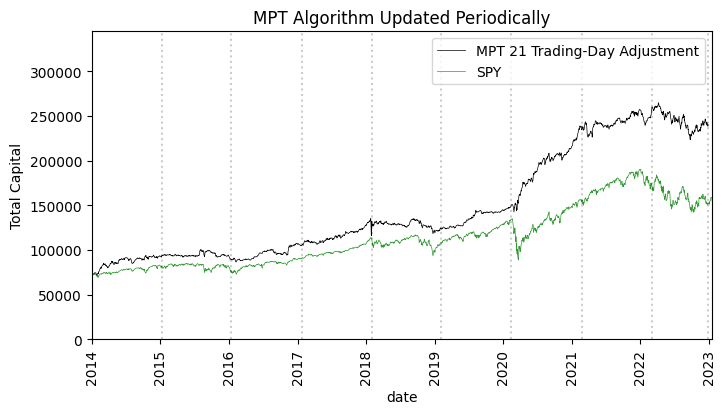

Final Date:  2022-12-29


In [66]:
plt.figure(figsize = [8,4])
plt.title('MPT Algorithm Updated Periodically')
plt.plot(dates, profits, color = 'black', label = 'MPT %d Trading-Day Adjustment' % weight_update_freq, linewidth = 0.5)
plt.plot(df.loc[df.Date >= start_date_mpt, 'Date'], df.loc[df.Date >= start_date_mpt, 'SPY_close']/(df.loc[df.Date >= start_date_mpt, 'SPY_close'].iloc[0])*starting_money, label = 'SPY', color = 'green', alpha = 0.8, linewidth = 0.5)
plt.xticks(rotation=90)

#print(profits)


#plt.ylim(0, 1.5*np.max(profits))
plt.xlim(dates[0], dates[-1] + dt.timedelta(days = 20))
plt.ylim(0, 1.3 * max(profits) )
plt.ylabel('Total Capital')
plt.xlabel('date')
is_over = False
i = 0

while not(is_over):
    if (i+1)*252 > len(dates):
        is_over = True

    year_ind = min((i+1)*252, len(dates)) - 1
    try:
        print('year %d returns %.1f percent' % (i+1, 100*profits[year_ind]/profits[i*252] - 100))
        plt.vlines(dates[year_ind], 0, 2*np.max(profits), color = 'black', alpha = 0.2, linestyle = ':')
    except:
        pass
    i += 1


pct = pd.Series(profits).pct_change()
SR = pct.mean()/pct.std()

print('Portfolio Sharpe Ratio (annualized): %.3f' %(SR * np.sqrt(252)))
plt.legend()
plt.show()

print('Final Date: ', dates[-1].date())

In [67]:
anim = animate(np.arange(0, len(weight_history), int(weight_update_freq/2)), duration=30)
HTML(anim.to_html5_video())

2022-12-29 00:00:00
GOOG_close     173.960007
AAPL_close         192.25
META_close     466.829987
GOOGL_close         172.5
TSLA_close     178.080002
                  ...    
RCL_close      147.679993
POWL_close     179.860001
LAKE_close          18.43
BMA_close       66.290001
SSTK_close      40.630001
Name: 5757, Length: 81, dtype: object


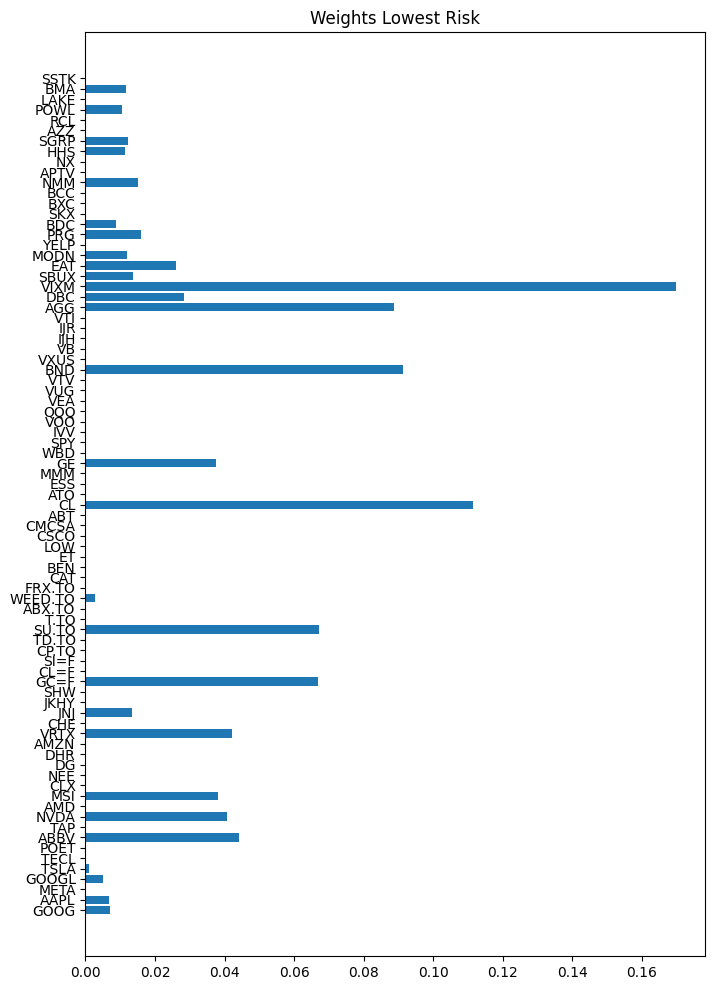

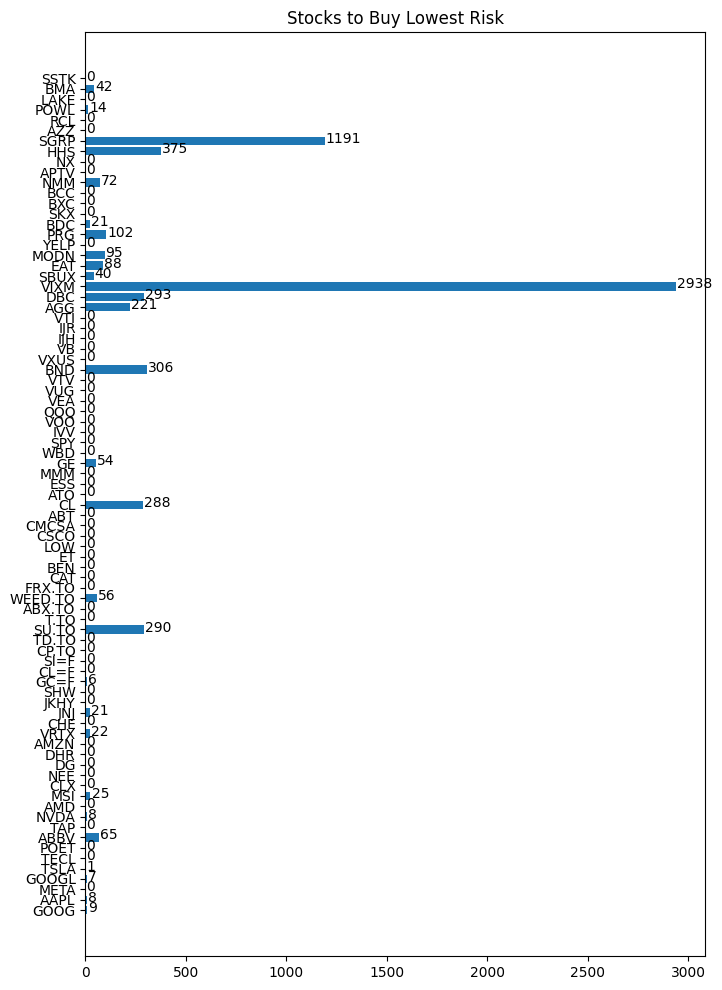

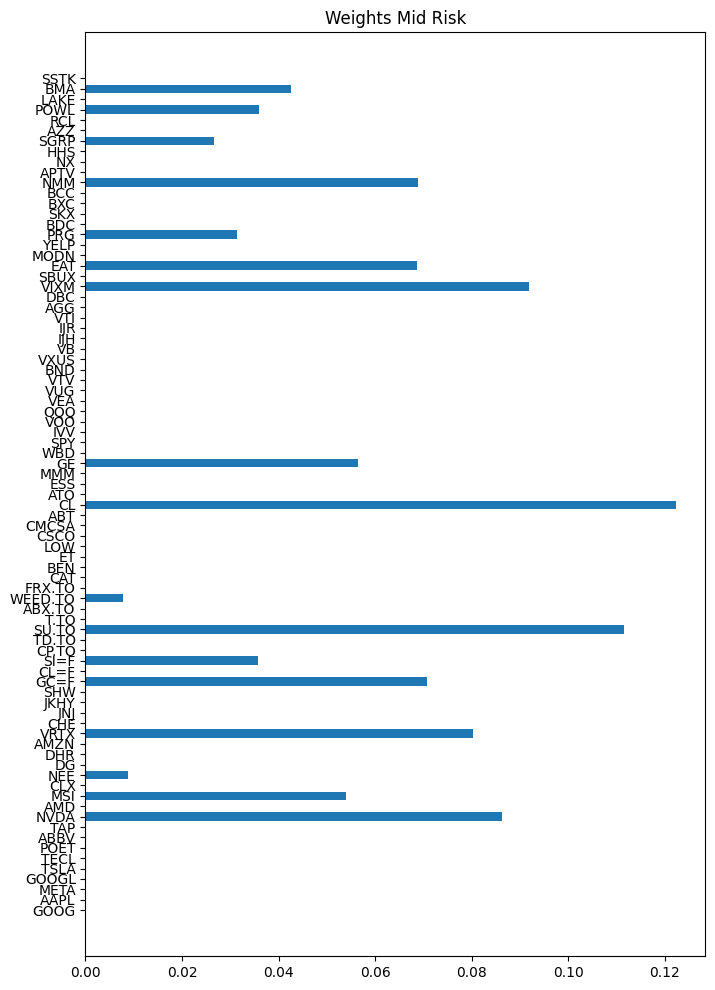

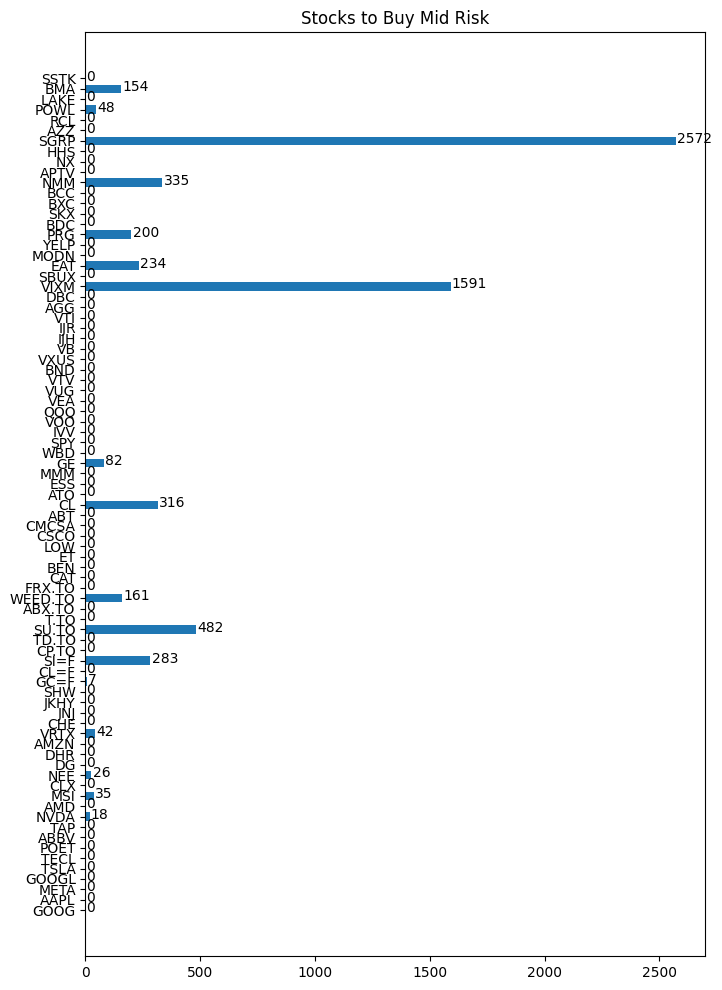

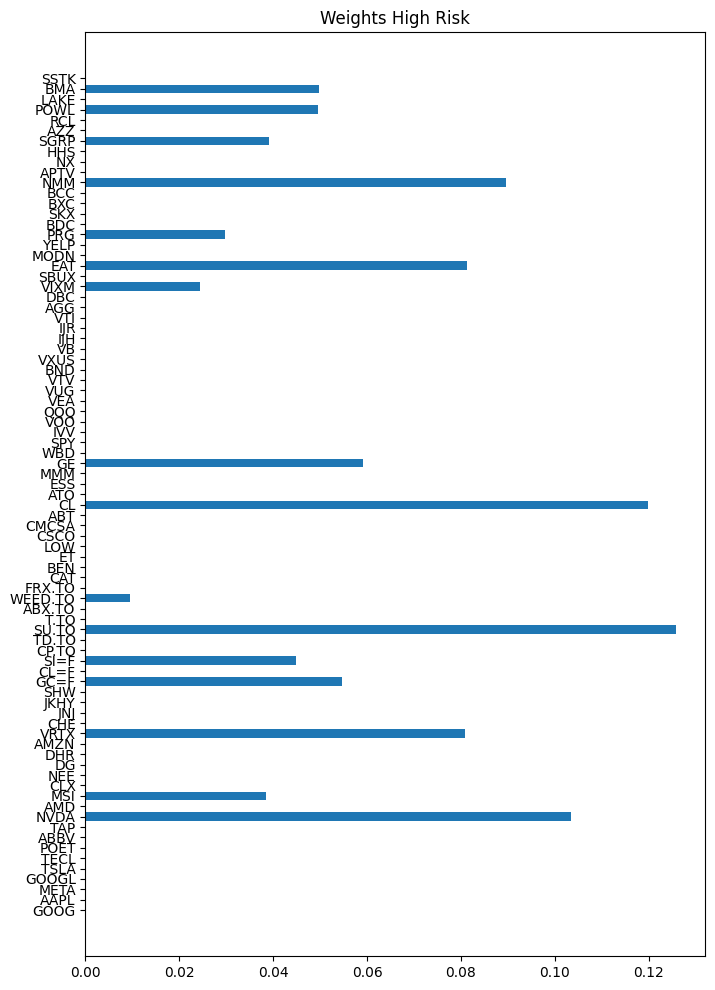

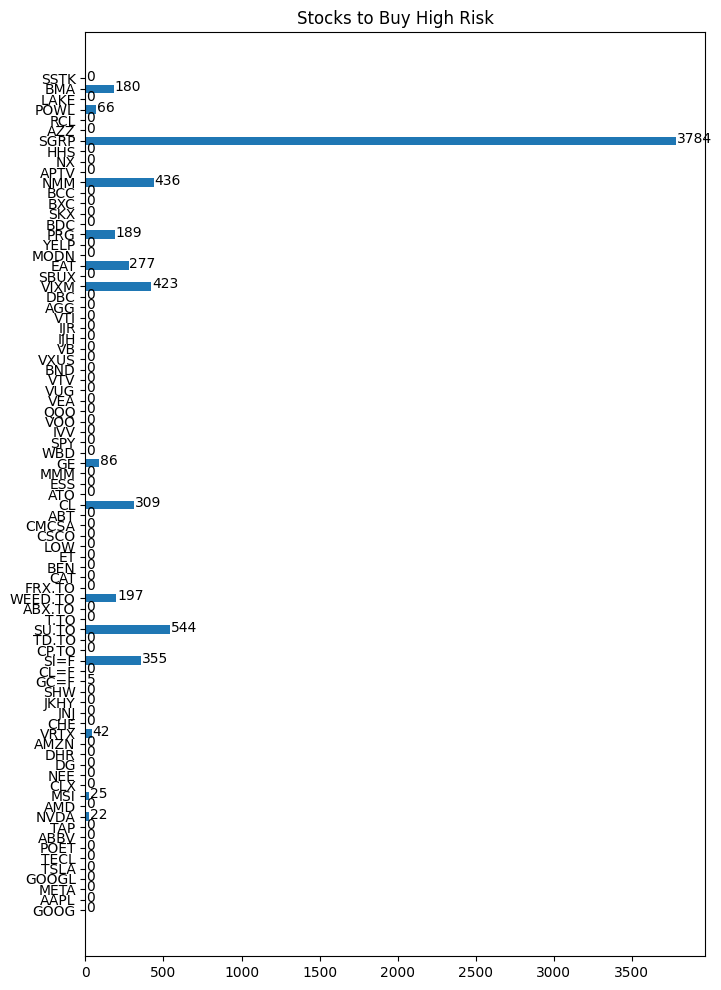

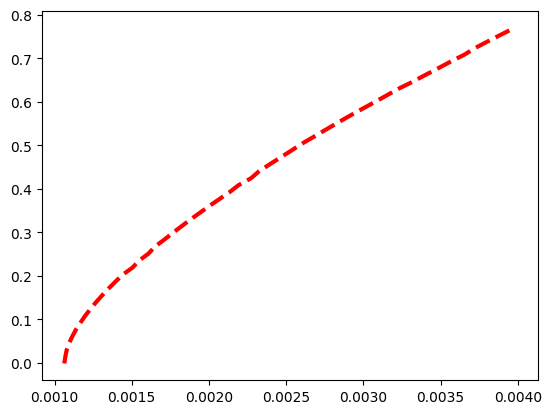

In [68]:
# most up to date recommendation:

#df = df.dropna(subset = feats)
#print(df[['Date', *feats]].tail(20).to_markdown())


#current_money = 0.73 * current_money_cad

last_day = dates[-1]
print(last_day)
lookback_ind = df[df.Date >= last_day - lookback].index[0]

data = df.iloc[lookback_ind:-2]
discount_factor = np.exp(- np.arange(len(data)-1, -1, -1) / decay_tau)


#means       = data[feats].mean()
means = np.sum(data[feats].multiply(discount_factor, axis=0)) / np.sum(discount_factor)
covariances = data[feats].multiply(discount_factor, axis=0).cov() / np.sum(discount_factor)


maxSR_dataframe, minvar_dataframe, efficient_weights, efficient_front = get_all_results(
                                                                                        means, 
                                                                                        covariances, 
                                                                                        riskfreerate=0.05, 
                                                                                        weight_range=(0, 0.18), 
                                                                                        N_steps=50
                                                                                        )

stock_val_today = df.iloc[df.index[-3]][close_feats]
print(stock_val_today)

titles = ['Lowest', 'Mid', 'High']

for n, risk in enumerate((0.3, 0.8, 0.999)):

    
    weights = efficient_weights[int((len(efficient_weights)-1) * risk)]
    plt.figure(figsize = [8, 12])
    plt.title('Weights %s Risk' % titles[n])
    plt.barh(np.arange(len(stock_list)), weights)
    plt.yticks(np.arange(len(stock_list)), stock_list)
    plt.show()

    

    stocks_owned =  np.floor(weights * (current_money/stock_val_today))

    plt.figure(figsize = [8, 12])
    plt.title('Stocks to Buy %s Risk' % titles[n])
    plt.barh(np.arange(len(stock_list)), stocks_owned)
    plt.yticks(np.arange(len(stock_list)), stock_list)
    for i, stock in enumerate(stocks_owned.index):
        plt.text(stocks_owned[stock] + 5, i-0.2, str(stocks_owned[stock]))
    plt.show()


plt.plot(efficient_front[1], efficient_front[0], color = 'red', linestyle = '--', linewidth = 3, label = 'efficient frontier')
plt.show()